# Experiment 3

The goal of this experiment was implement a simple reference game between a sender and a receiver with overcomplete vocabulary using a fully-differentiable autoencoder. I was interested whether discrete alphabet could emerge only by imposing L0/L1 regularization. This setting is known as sparse autoencoder.

This results is interesting, because it shows that (1) we can avoid using policy gradients/reinforcement learning and optimize end-to-end through the population, (2) discrete vocabulary can emerge from a soft constraint added to loss function, (3) significant rendundancy can still arise despite this constraint.

In [198]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
from torch.optim import Adam
import seaborn as sns

torch.manual_seed(1773)
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [170]:
class SparseAutoencoder(nn.Module):
    def __init__(self, input_size, alphabet_size, output_size):
        super(SparseAutoencoder, self).__init__()
        self.sender = nn.Embedding(input_size, alphabet_size)
        self.receiver = nn.Linear(alphabet_size, output_size)

    def forward(self, x):
        encoded = self.sender(x).abs_()
        decoded = F.softmax(self.receiver(encoded), dim=1)
        return encoded, decoded
    
def get_loss(reconstruction_loss, encoded, p=1, regularization_coefficient=0.1):
    return reconstruction_loss + regularization_coefficient * torch.norm(encoded, p=p)

In [171]:
class DifferentiableWorld:
    def __init__(self, batch_size, world_size):
        self.batch_size, self.world_size = batch_size, world_size
        self.reset()
    
    def reset(self):
        self.hidden_state = torch.randint(
            high=self.world_size, 
            size=(self.batch_size,),
            dtype=torch.long
        )
    
    def receive_observation(self):
        return self.hidden_state
    
    def evaluate_prediction(self, pred):
        return F.nll_loss(pred, self.hidden_state)

In [178]:
class SenderReceiverSystem:
    
    def __init__(self, world_size, learning_rate=0.1, alphabet_size=25):
        self.net = SparseAutoencoder(input_size=world_size, alphabet_size=alphabet_size, output_size=world_size)
        self.optimizer = Adam(params=self.net.parameters(), lr=learning_rate, weight_decay=1e-6)
          
    def choose_action(self, observation):
        return self.net(observation)
    
    def teach(self, reconstruction_loss, encoded, p, regularization_coefficient):
        self.optimizer.zero_grad()  
        loss = get_loss(reconstruction_loss, encoded, p, regularization_coefficient)
        loss.backward()
        self.optimizer.step()
        return loss

In [188]:
def train(p, regularization_coefficient):
    system = SenderReceiverSystem(world_size=10, alphabet_size=15)
    world = DifferentiableWorld(batch_size=10, world_size=10)
    for epoch in range(10000):
        observation = world.receive_observation()
        encoded, prediction = system.choose_action(observation)
        loss = world.evaluate_prediction(prediction)
        system.teach(loss, encoded, p, regularization_coefficient)
        world.reset()
        if epoch % 1000 == 0:
            print(f'Epoch {epoch}, loss {loss:.2f}, encoding l{p}-norm {encoded.norm(p=1):.2f}')
            print(observation, prediction.argmax(dim=1))
    return encoded

In [189]:
def visualize_codebook(encoded):
    sns.heatmap(encoded.detach().numpy(), annot=True, fmt='.2f')

Epoch 0, loss -0.08, encoding l1-norm 95.99
tensor([1, 4, 2, 1, 7, 4, 3, 4, 8, 8]) tensor([3, 9, 9, 3, 5, 9, 3, 9, 0, 0])
Epoch 1000, loss -0.29, encoding l1-norm 6.88
tensor([5, 3, 4, 9, 8, 0, 1, 6, 2, 8]) tensor([7, 7, 7, 7, 8, 7, 7, 7, 2, 8])
Epoch 2000, loss -0.10, encoding l1-norm 6.04
tensor([4, 6, 6, 4, 5, 9, 0, 6, 3, 7]) tensor([7, 7, 7, 7, 2, 7, 7, 7, 7, 7])
Epoch 3000, loss -0.39, encoding l1-norm 8.73
tensor([7, 1, 0, 0, 0, 3, 8, 5, 7, 0]) tensor([7, 1, 7, 7, 7, 7, 8, 7, 7, 7])
Epoch 4000, loss -0.70, encoding l1-norm 7.16
tensor([8, 0, 0, 2, 4, 2, 6, 3, 3, 4]) tensor([8, 0, 0, 2, 4, 2, 6, 2, 2, 4])
Epoch 5000, loss -0.98, encoding l1-norm 8.41
tensor([0, 9, 3, 0, 1, 2, 1, 1, 1, 0]) tensor([0, 9, 3, 0, 1, 2, 1, 1, 1, 0])
Epoch 6000, loss -0.99, encoding l1-norm 6.27
tensor([0, 9, 7, 9, 8, 0, 3, 8, 0, 4]) tensor([0, 9, 7, 9, 8, 0, 3, 8, 0, 4])
Epoch 7000, loss -0.71, encoding l1-norm 5.54
tensor([6, 2, 5, 0, 9, 9, 0, 3, 8, 6]) tensor([6, 2, 5, 0, 8, 8, 0, 0, 8, 6])
Epoch 8000

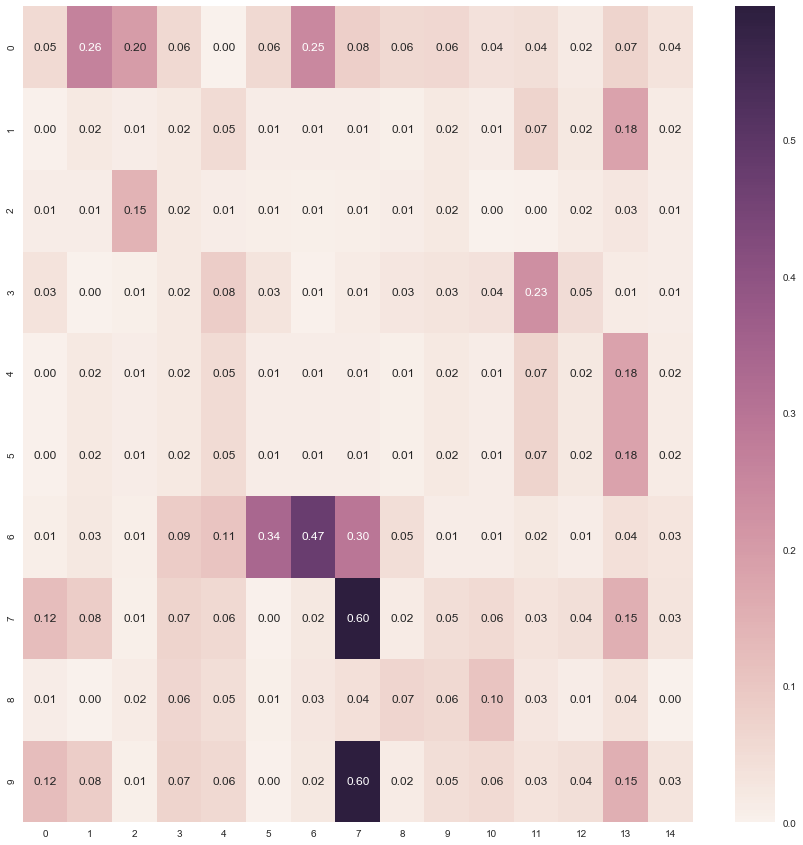

In [190]:
encoded = train(p=1, regularization_coefficient=0.1)
print('Sender\'s activations')
visualize_codebook(encoded)

With mild regularization, the neural networks learns its tasks but fails to use discerete hidden states

Epoch 0, loss -0.09, encoding l1-norm 126.13
tensor([2, 1, 6, 4, 1, 2, 6, 1, 0, 5]) tensor([4, 5, 4, 4, 5, 4, 4, 5, 4, 2])
Epoch 1000, loss -0.30, encoding l1-norm 5.71
tensor([6, 6, 4, 8, 5, 2, 4, 5, 4, 0]) tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4])
Epoch 2000, loss -0.10, encoding l1-norm 4.99
tensor([1, 5, 4, 8, 9, 6, 1, 2, 6, 1]) tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4])
Epoch 3000, loss -0.10, encoding l1-norm 5.13
tensor([7, 8, 7, 3, 1, 4, 1, 0, 3, 1]) tensor([8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
Epoch 4000, loss -0.10, encoding l1-norm 6.08
tensor([0, 2, 1, 2, 8, 3, 8, 5, 4, 3]) tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4])
Epoch 5000, loss -0.30, encoding l1-norm 4.54
tensor([4, 2, 6, 4, 7, 4, 7, 9, 5, 5]) tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4])
Epoch 6000, loss -0.10, encoding l1-norm 5.85
tensor([6, 6, 4, 8, 6, 2, 1, 5, 8, 2]) tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4])
Epoch 7000, loss -0.10, encoding l1-norm 4.99
tensor([8, 0, 5, 9, 3, 5, 1, 5, 0, 2]) tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2])
Epoch 800

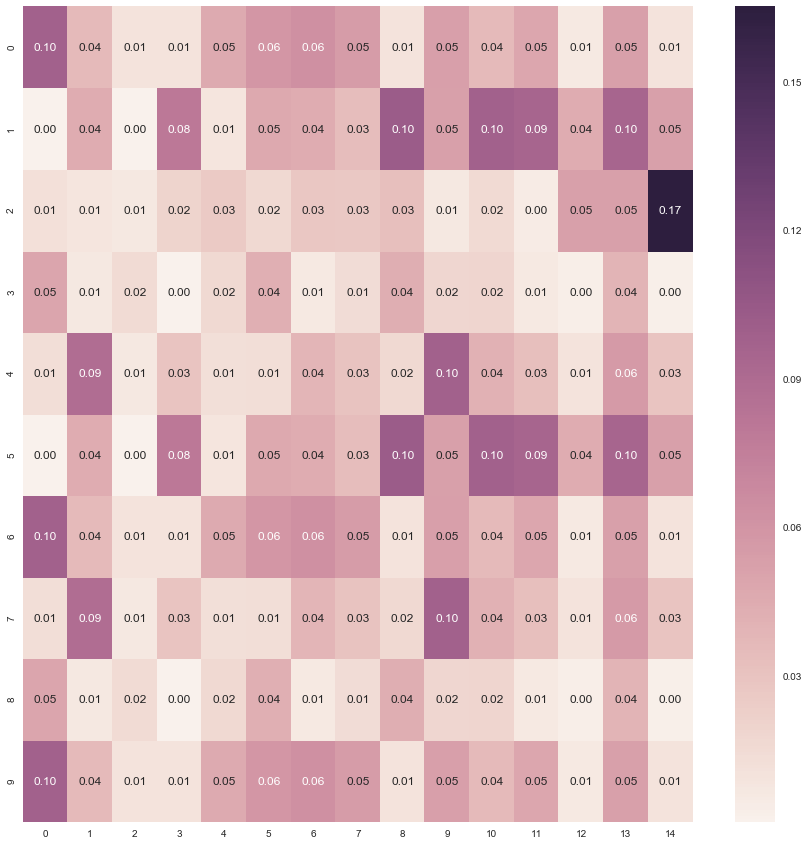

In [191]:
encoded = train(p=1, regularization_coefficient=1)
print('Sender\'s activations')
visualize_codebook(encoded)

With stronger regularization, the network fails to learn its task.

Epoch 0, loss -0.09, encoding l0-norm 123.37
tensor([8, 9, 6, 4, 1, 4, 4, 5, 3, 6]) tensor([8, 1, 8, 8, 8, 8, 8, 8, 8, 8])
Epoch 1000, loss -1.00, encoding l0-norm 165.67
tensor([9, 4, 3, 5, 5, 5, 3, 4, 3, 1]) tensor([9, 4, 3, 5, 5, 5, 3, 4, 3, 1])
Epoch 2000, loss -1.00, encoding l0-norm 130.77
tensor([3, 5, 9, 3, 9, 4, 3, 9, 0, 5]) tensor([3, 5, 9, 3, 9, 4, 3, 9, 0, 5])
Epoch 3000, loss -1.00, encoding l0-norm 109.14
tensor([3, 2, 7, 5, 1, 3, 1, 1, 6, 5]) tensor([3, 2, 7, 5, 1, 3, 1, 1, 6, 5])
Epoch 4000, loss -1.00, encoding l0-norm 101.08
tensor([5, 2, 2, 2, 1, 2, 8, 8, 8, 6]) tensor([5, 2, 2, 2, 1, 2, 8, 8, 8, 6])
Epoch 5000, loss -1.00, encoding l0-norm 88.33
tensor([8, 2, 6, 0, 5, 8, 6, 6, 5, 7]) tensor([8, 2, 6, 0, 5, 8, 6, 6, 5, 7])
Epoch 6000, loss -1.00, encoding l0-norm 81.31
tensor([4, 3, 0, 0, 2, 6, 5, 3, 6, 1]) tensor([4, 3, 0, 0, 2, 6, 5, 3, 6, 1])
Epoch 7000, loss -1.00, encoding l0-norm 79.99
tensor([9, 9, 3, 1, 4, 3, 8, 9, 7, 2]) tensor([9, 9, 3, 1, 4, 3, 8, 9, 7, 2]

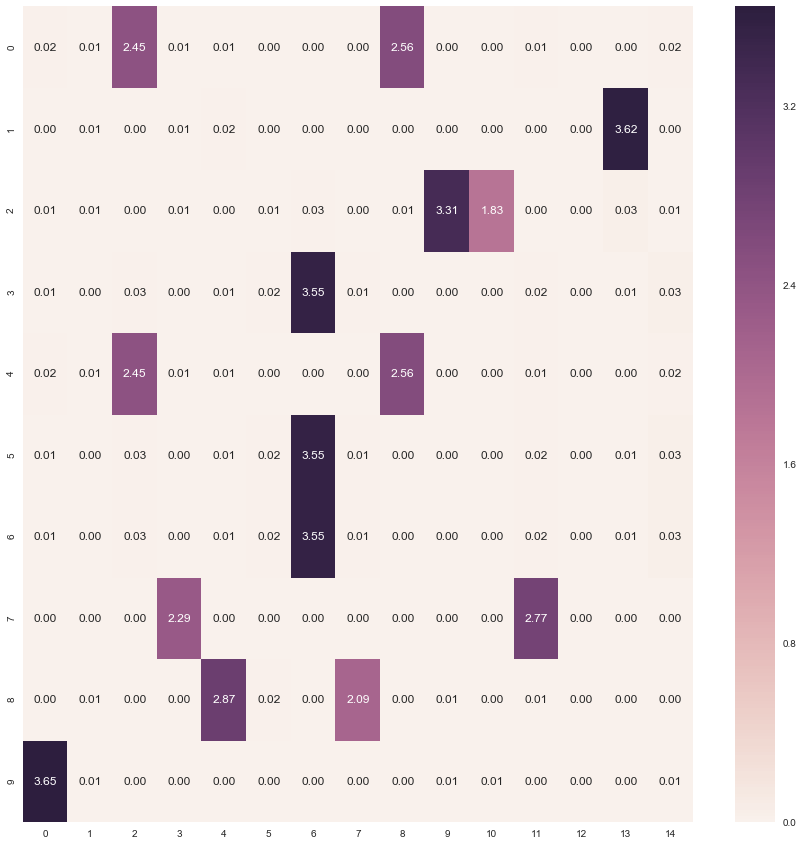

In [195]:
encoded = train(p=0, regularization_coefficient=0.1)
print('Sender\'s activations')
visualize_codebook(encoded)

Epoch 0, loss -0.08, encoding l0-norm 119.23
tensor([9, 2, 7, 2, 4, 0, 4, 7, 7, 0]) tensor([5, 5, 5, 5, 1, 8, 1, 5, 5, 8])
Epoch 1000, loss -1.00, encoding l0-norm 142.30
tensor([0, 8, 8, 0, 7, 9, 8, 1, 2, 4]) tensor([0, 8, 8, 0, 7, 9, 8, 1, 2, 4])
Epoch 2000, loss -1.00, encoding l0-norm 122.99
tensor([1, 6, 7, 4, 7, 1, 0, 5, 7, 5]) tensor([1, 6, 7, 4, 7, 1, 0, 5, 7, 5])
Epoch 3000, loss -1.00, encoding l0-norm 96.56
tensor([5, 0, 1, 0, 8, 6, 9, 4, 8, 1]) tensor([5, 0, 1, 0, 8, 6, 9, 4, 8, 1])
Epoch 4000, loss -1.00, encoding l0-norm 97.59
tensor([7, 0, 7, 1, 0, 0, 5, 8, 1, 4]) tensor([7, 0, 7, 1, 0, 0, 5, 8, 1, 4])
Epoch 5000, loss -1.00, encoding l0-norm 93.82
tensor([5, 8, 4, 5, 0, 9, 5, 5, 9, 3]) tensor([5, 8, 4, 5, 0, 9, 5, 5, 9, 3])
Epoch 6000, loss -1.00, encoding l0-norm 81.21
tensor([6, 6, 5, 4, 0, 8, 2, 8, 6, 0]) tensor([6, 6, 5, 4, 0, 8, 2, 8, 6, 0])
Epoch 7000, loss -1.00, encoding l0-norm 79.30
tensor([6, 0, 6, 4, 0, 5, 5, 9, 0, 9]) tensor([6, 0, 6, 4, 0, 5, 5, 9, 0, 9])


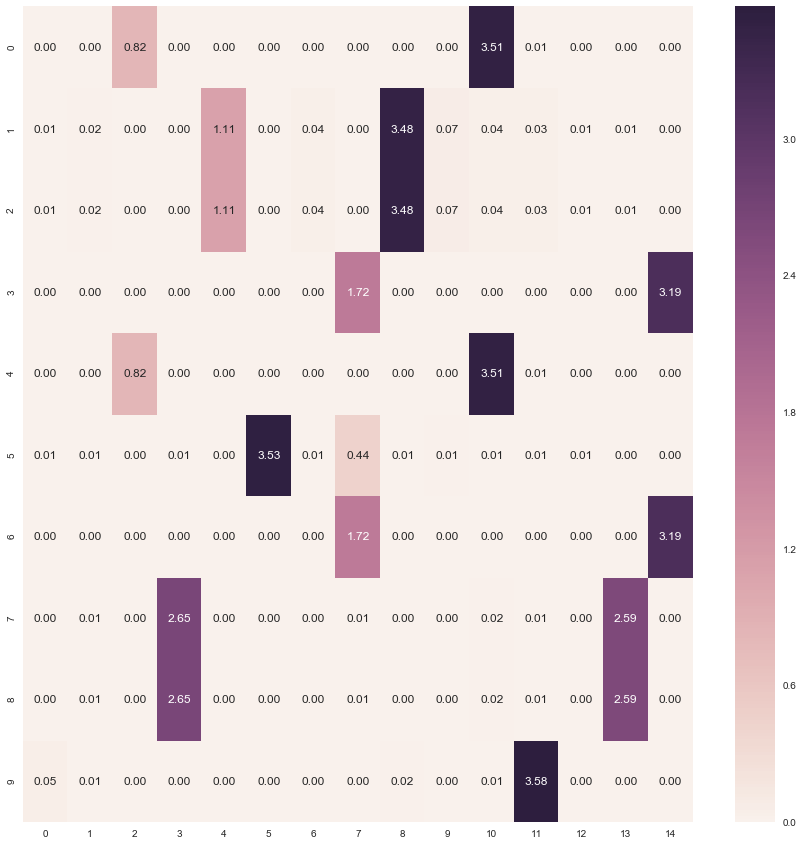

In [196]:
encoded = train(p=0, regularization_coefficient=5)
print('Sender\'s activations')
visualize_codebook(encoded)

In [197]:
observation

tensor([4, 0, 0, 7, 0, 4, 4, 6, 8, 4])

With strong L0 regularization, a discrete but not one-to-one mapping emerges.